## 3.2 Analysis

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point
import pandas as pd
import numpy as np
from matplotlib.cm import ScalarMappable

%matplotlib inline

In [2]:
from fiona.crs import from_string
street_map = gpd.read_file('lcsd000a19a_e/lcsd000a19a_e.shp')
# crs = {'init': 'epsg:4326'}
crs = from_string("+proj=longlat +datum=WGS84 +no_defs")
street_map = street_map.to_crs(crs=crs)

The Shapefile was obtained from [StatCan](https://www12.statcan.gc.ca/census-recensement/alternative_alternatif.cfm?l=eng&dispext=zip&teng=lcsd000a19a_e.zip&k=%20%20%20%2015394&loc=http://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/files-fichiers/lcsd000a19a_e.zip)

In [3]:
%run -i eqw.py # execute the PySpark script in Notebook
df_pd = df.toPandas() # bringing processed sampleData from pyspark into Pandas
df_temp = df_temp.toPandas() # bringing POI dataframe with mean and stddev from pyspark into Pandas

In [4]:
# recreate the POI.csv into a DataFrame
df_poi = pd.read_csv("data/POIList.csv")
df_poi.columns= [x.replace(" ", "").lower() for x in df_poi.columns.tolist()] 
df_poi.astype({"latitude": "float", "longitude": "float"});
df_poi = pd.merge(df_poi, df_temp, on="poiid")

In [5]:
# creating Point variables from shapely
geometry = [Point(xy) for xy in zip(df_pd["longitude"], df_pd["latitude"])]

poi_geometry = [Point(xy) for xy in zip(df_poi["longitude"], df_poi["latitude"])]

In [6]:
# Pythagorean theorem as a function to calculate distance between each POI and its furthest request 
# used as radius for circle projection 
def pythag(df):
    pythag = sqrt((df["latitude"] - df["max_lat"])**2 + (df["longitude"] - df["max_lon"])**2)
    return pythag

In [7]:
# GeoDataFrame of the Requests
geo_df = gpd.GeoDataFrame(df_pd, crs=crs, geometry=geometry)
geo_df = geo_df.loc[(geo_df["longitude"] < 0)] # drop wrongly labelled data; i.e. lat-lon coordinates in Philippines being incorrectly labelled as being in Canada 
geo_df.reset_index(inplace=True)

# GeoDataFrame of the POIs
geo_poi = gpd.GeoDataFrame(df_poi, crs=crs, geometry=poi_geometry)
max_dist = {x:geo_df["closest_dist"][geo_df["poiid"] == x].max() for x in geo_df["poiid"].unique().tolist()}
max_lat = {x: geo_df["latitude"][geo_df["closest_dist"] == max_dist[x]].max() for x in geo_df["poiid"].unique().tolist()} 
max_lon = {x: geo_df["longitude"][geo_df["closest_dist"] == max_dist[x]].max() for x in geo_df["poiid"].unique().tolist()}
geo_poi["max_dist"] = [max_dist[x] for x in geo_poi["poiid"]]
geo_poi["max_lat"] = [max_lat[x] for x in geo_poi["poiid"]]
geo_poi["max_lon"] = [max_lon[x] for x in geo_poi["poiid"]]
geo_poi["plot_radius"] = geo_poi.apply(pythag, axis=1) # trigonometric calculation of distance between POI to its' furthest request in order to plot circles


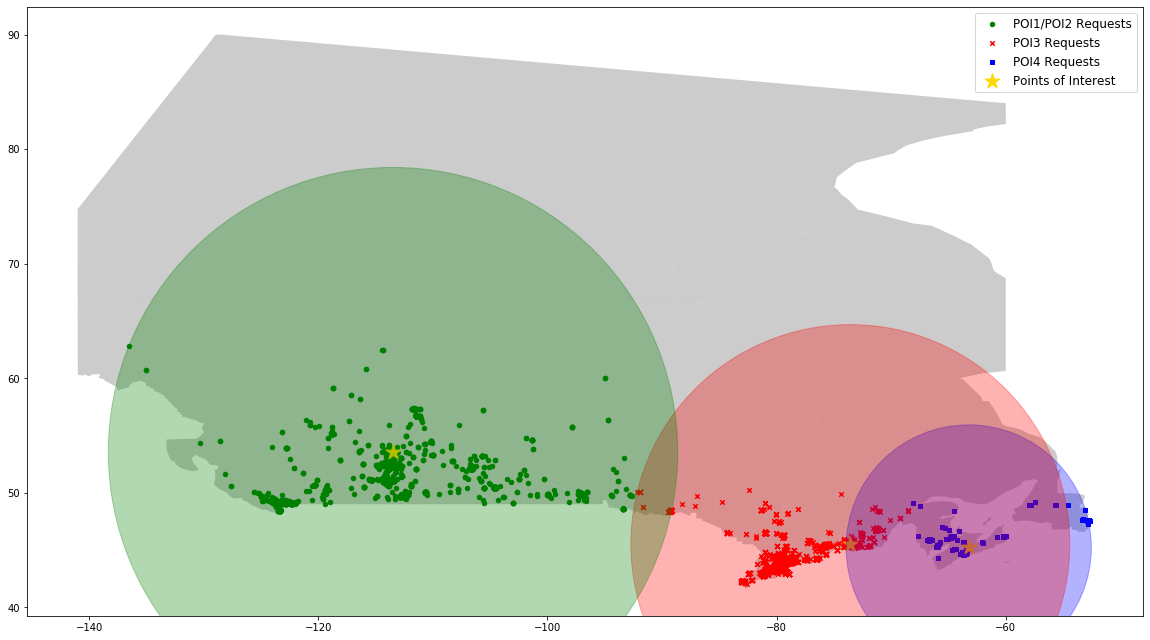

In [8]:
fig,ax = plt.subplots(figsize = (20,20))
street_map.plot(ax=ax, alpha=0.4, color='grey')

geo_df[(geo_df["poiid"] == "POI2")].plot(ax=ax, markersize=20, color='green', marker='o', label='POI1/POI2 Requests')
geo_df[geo_df["poiid"] == "POI3"].plot(ax=ax, markersize=20, color='red', marker='x', label='POI3 Requests')
geo_df[geo_df["poiid"] == "POI4"].plot(ax=ax, markersize=20, color='blue', marker='s', label='POI4 Requests')
geo_poi[geo_poi["poiid"]=="POI1"].plot(ax=ax, markersize=250, color='gold', marker='*', label="Points of Interest")
geo_poi[geo_poi["poiid"]=="POI3"].plot(ax=ax, markersize=250, color='gold', marker='*')
geo_poi[geo_poi["poiid"]=="POI4"].plot(ax=ax, markersize=250, color='gold', marker='*')
ax.add_artist(plt.Circle((geo_poi["longitude"][geo_poi["poiid"] == "POI4"], geo_poi["latitude"][geo_poi["poiid"] == "POI4"]),geo_poi["plot_radius"][geo_poi["poiid"] == "POI4"], alpha=0.3, color='blue'))
ax.add_artist(plt.Circle((geo_poi["longitude"][geo_poi["poiid"] == "POI3"],geo_poi["latitude"][geo_poi["poiid"] == "POI3"]), geo_poi["plot_radius"][geo_poi["poiid"] == "POI3"], alpha=0.3, color='red'))
ax.add_artist(plt.Circle((geo_poi["longitude"][geo_poi["poiid"] == "POI1"], geo_poi["latitude"][geo_poi["poiid"] == "POI1"]),geo_poi["plot_radius"][geo_poi["poiid"] == "POI1"], alpha=0.3, color='green'))

plt.legend(prop={'size': 12});
plt.savefig("map_poi.png")

In [9]:
# to calculate density (requests/area), area calculated in kilometres using polygon.area
# to find number of requests per POI, use 'within', iterating through entire datasample DataFrame

geo_poi["polygon_plot"] = geo_poi["geometry"].buffer(geo_poi["plot_radius"])
# this is the polygon in plotting scale

geo_poi["polygon_km"] = geo_poi["geometry"].buffer(geo_poi["max_dist"])
# this is polygon in kilometres

polygon_dict = {row.poiid: [row.polygon_plot, row.polygon_km] for row in geo_poi.itertuples()}
density = []

for poi,polygon in polygon_dict.items():
    i = 0
    for geometry in geo_df["geometry"]:
        if geometry.within(polygon[0]):
            i+=1
    density.append({poi: i/polygon[1].area})   

geo_poi["density_req/km"] = [list(i.values())[0] for i in density] 
# area is calculated in km, so requests per kilometre

## 4a. Model

In [10]:
def scaler(x, min1, max1, min2, max2):
    return (((max2-min2)*(x-min1)/(max1-min1))+min2)

scale_min = -10
scale_max = 10

geo_poi["scaled_density"] = [scaler(x, 0, geo_poi["density_req/km"].max()*1.3, scale_min, scale_max) for x in geo_poi["density_req/km"]]
# "max1" is evaluated to be 30% more to cover edge cases of extreme popularity
# "min1" is set to 0 to account for lowest possible popularity

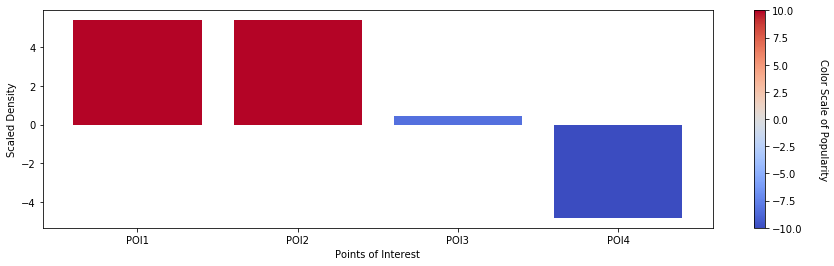

In [11]:
data_poi = geo_poi["poiid"]
data_height = geo_poi["scaled_density"]

data_color = [poi/geo_poi["scaled_density"].max() for poi in geo_poi["scaled_density"]]
fig, ax = plt.subplots(figsize=(15,4))

poi_cmap = plt.cm.get_cmap("coolwarm")
colors = poi_cmap(data_color)
rects = ax.bar(data_poi, data_height, color=colors)

sm = ScalarMappable(cmap=poi_cmap, norm=plt.Normalize(scale_min, scale_max))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Color Scale of Popularity', rotation=270, labelpad=25)

plt.xticks(data_poi)
plt.ylabel("Scaled Density")
plt.xlabel("Points of Interest")
plt.savefig("poi_popularity.png")
plt.show();